<a href="https://colab.research.google.com/github/worker2396/uni/blob/main/Copy_of_Czesc1_2022_Odkrywanie_modeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wprowadzenie do eksploracji procesów (*process mining*)

Główną klasą problemów z dziedziny eksploracji procesów jest odkrywanie procesów na podstawie dzienników zdarzeń. 
Metody odkrywania procesów biznesowych z danych pozwalają na budowę modeli procesów biznesowych i zobrazowanie rzeczywistych działań zachodzących w organizacjach, a nie jedynie hipotetycznego modelu opracowanego przez analityków.

W celu odkrycia modelu potrzebujemy dziennik zdarzeń (*event log*). Taki dziennik może być dostępny bezpośrednio w systemie (wiele systemów w dzisiejszych czasach loguje zachodzące w nich zdarzenia w specjalnych formatach dzienników zdarzeń) lub może być być utworzony z danych dostępnych w naszych bazach danych:
  * w prosty sposób np. z danych o transakcjach w sklepie internetowym, czy zachowaniu użytkowników systemu (kiedy, co i przez kogo zostało kliknięte w systemie), lub 
  * w nieco bardziej skomplikowany sposób z danych nieustrukturyzowanych, takich jak np. e-maile, obraz z kamery itp. 

## Konfiguracja środowiska


In [168]:
!apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [169]:
!pip install pygraphviz

## Pobranie przykładowych danych dla naszego logu

Aby móc odkryć model procesu potrzebujemy danych, na bazie których będziemy próbowali ten model skonstruować. Dane możemy albo wczytywać bezpośrednio z serwera albo pobrać je i wczytywać z lokalnego pliku. 

Ponieważ plik z naszymi danymi dot. procesu napraw telefonów nie jest bardzo duży spróbujmy go pobrać w celu późniejszego przetwarzania. 

In [170]:
!wget http://home.agh.edu.pl/~kluza/repairExample.csv

--2022-03-16 18:37:17--  http://home.agh.edu.pl/~kluza/repairExample.csv
Resolving home.agh.edu.pl (home.agh.edu.pl)... 149.156.98.66, 2001:6d8:10:1127::6242
Connecting to home.agh.edu.pl (home.agh.edu.pl)|149.156.98.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1304360 (1.2M) [text/csv]
Saving to: ‘repairExample.csv.6’

repairExample.csv.6 100%[===================>]   1.24M  1.33MB/s    in 0.9s    

2022-03-16 18:37:19 (1.33 MB/s) - ‘repairExample.csv.6’ saved [1304360/1304360]



## Importowanie modułów

W celu odkrycia napisania prostego programu odkrywającego prototyp modelu procesu skorzystamy z kilku dostępnych modułów dla języka Python:

In [171]:
import pandas as pd
from functools import reduce
from itertools import groupby
from itertools import chain
from more_itertools import pairwise
from collections import Counter
import pygraphviz as pgv
from IPython.display import Image, display

##Wczytanie danych

Wczytaj dane z pliku csv i przejrzyj je, a następnie używając funkcji z narzędzia pandas spróbuj odpowiedzieć na pytania związane z dziennikiem zdarzeń.

In [172]:
df = pd.read_csv('repairExample.csv')
df.head(10)

,Case ID,Activity,Resource,Start Timestamp,Complete Timestamp,Variant,Variant index,(case) creator,(case) variant,(case) variant-index,concept:name,defectFixed,defectType,lifecycle:transition,numberRepairs,org:resource,phoneType
0,1,Register,System,1970/01/02 12:23:00.000,1970/01/02 12:23:00.000,Variant 2,2,Fluxicon Disco,Variant 2,2,Register,NaN,NaN,complete,NaN,System,NaN
1,1,Analyze Defect,Tester3,1970/01/02 12:23:00.000,1970/01/02 12:30:00.000,Variant 2,2,Fluxicon Disco,Variant 2,2,Analyze Defect,NaN,6,complete,NaN,Tester3,T2
2,1,Repair (Complex),SolverC1,1970/01/02 12:31:00.000,1970/01/02 12:49:00.000,Variant 2,2,Fluxicon Disco,Variant 2,2,Repair (Complex),NaN,NaN,complete,NaN,SolverC1,NaN
3,1,Test Repair,Tester3,1970/01/02 12:49:00.000,1970/01/02 12:55:00.000,Variant 2,2,Fluxicon Disco,Variant 2,2,Test Repair,true,NaN,complete,0,Tester3,NaN
4,1,Inform User,System,1970/01/02 13:10:00.000,1970/01/02 13:10:00.000,Variant 2,2,Fluxicon Disco,Variant 2,2,Inform User,NaN,NaN,complete,NaN,System,NaN
5,1,Archive Repair,System,1970/01/02 13:10:00.000,1970/01/02 13:10:00.000,Variant 2,2,Fluxicon Disco,Variant 2,2,Archive Repair,true,NaN,complete,0,System,NaN
6,1,End,End,1970/01/02 13:10:00.000,1970/01/02 13:10:00.000,Variant 2,2,Fluxicon Disco,Variant 2,2,End,End,End,complete,End,End,End
7,10,Register,System,1970/01/01 11:09:00.000,1970/01/01 11:09:00.000,Variant 8,8,Fluxicon Disco,Variant 8,8,Register,NaN,NaN,complete,NaN,System,NaN
8,10,Analyze Defect,Tester2,1970/01/01 11:09:00.000,1970/01/01 11:15:00.000,Variant 8,8,Fluxicon Disco,Variant 8,8,Analyze Defect,NaN,3,complete,NaN,Tester2,T1
9,10,Repair (Simple),SolverS1,1970/01/01 11:35:00.000,1970/01/01 11:42:00.000,Variant 8,8,Fluxicon Disco,Variant 8,8,Repair (Simple),NaN,NaN,complete,NaN,SolverS1,NaN


* Ile jest wszystkich zdarzeń w logu? 

*   Wśród pracowników (*Resource*) możemy wyróżnić m.in. testerów i solverów. Ilu różnych testerów oraz solverów jest zaangażowanych w proces?



* Które zadanie (*Activity*) zajmuje najwięcej czasu? \\
(sposród wszystkich zadań, które w jakiejkolwiek instancji procesu trwało najdłużej)

Podpowiedź: Przekształć kolumny czasowe do typu `datetime`, tak aby móc wykonać stosowne obliczenia czasu.

In [173]:
df['start'] = pd.to_datetime(df['Start Timestamp'])
df.dtypes

Case ID                          int64
Activity                        object
Resource                        object
Start Timestamp                 object
Complete Timestamp              object
Variant                         object
Variant index                    int64
(case) creator                  object
(case) variant                  object
(case) variant-index             int64
concept:name                    object
defectFixed                     object
defectType                      object
lifecycle:transition            object
numberRepairs                   object
org:resource                    object
phoneType                       object
start                   datetime64[ns]
dtype: object

## Przygotowanie danych

W zależności od tego, w jaki sposób przygotujemy dane do odkrywania modelu, może to znacznie uprościć nam przetwarzanie. Na początek spróbujmy określić, w jakiej kolejności występowały zdarzenia w poszczególnych przypadkach, a zatem określimy jakie mamy w logu ślady/ścieżki (*traces*).  

Uprośćmy nieco nasz log, aby łatwiej przetwarzać dane:

In [174]:
dfs = df[['Case ID', 'Activity', 'start']]
dfs.head()

,Case ID,Activity,start
0,1,Register,1970-01-02 12:23:00
1,1,Analyze Defect,1970-01-02 12:23:00
2,1,Repair (Complex),1970-01-02 12:31:00
3,1,Test Repair,1970-01-02 12:49:00
4,1,Inform User,1970-01-02 13:10:00


Następnie zobaczmy, jak często wykonywane były poszczególne zadania:

In [191]:
ev_counter = dfs.Activity.value_counts()
ev_counter

def threshold_filter(threshold, counter_dict):
  for event, count in counter_dict.items():
    if count < threshold:
      counter_dict.pop(event)

threshold_filter(700, ev_counter)

ev_counter

dfs

SyntaxError: ignored

Na bazie identyfikatora przypadu (*Case ID*) pogrupujemy wszystkie zadania w ślady (*traces*):

In [176]:
dfs = (dfs
    .sort_values(by=['Case ID','start'])
    .groupby(['Case ID'])
    .agg({'Activity': ';'.join})
)

Zobaczmy zatem, jakie przykładowe ślady (instancje procesów) są w naszym logu:

In [177]:
dfs.head()

,Activity
Case ID,
1,Register;Analyze Defect;Repair (Complex);Test ...
2,Register;Analyze Defect;Inform User;Repair (Co...
3,Register;Analyze Defect;Repair (Simple);Inform...
4,Register;Analyze Defect;Repair (Simple);Inform...
5,Register;Analyze Defect;Repair (Complex);Test ...


Aby zobaczyć, jak dokładniej wygląda taki ślad, obejrzyjmy dowolny z takich śladów:

In [178]:
dfs.iloc[145]['Activity']

'Register;Analyze Defect;Repair (Simple);Test Repair;Inform User;Archive Repair;End'

Ponieważ ślady w logu mogą się powtarzać, zgrupujmy je zatem w warianty i policzmy ile jest śladów każdego typu:

In [179]:
dfs['count'] = 0
dfs = (
    dfs.groupby('Activity', as_index=False).count()
    .sort_values(['count'], ascending=False)
    .reset_index(drop=True)
    )

In [180]:
dfs.head()

,Activity,count
0,Register;Analyze Defect;Repair (Complex);Infor...,253
1,Register;Analyze Defect;Repair (Complex);Test ...,193
2,Register;Analyze Defect;Repair (Simple);Test R...,108
3,Register;Analyze Defect;Inform User;Repair (Co...,78
4,Register;Analyze Defect;Repair (Simple);Inform...,75


Jak wygląda najczęstszy ślad (najczęstsza ścieżka zdarzeń w procesie, czyli najpopularniejszy wariant)? 

Ponieważ w dalszej części wygodniej będzie nam operować na wariantach w formie listy, \\
dodamy nową kolumnę, która przechowa wariant w formie listy:

In [181]:
dfs['trace'] = [trace.split(';') for trace in dfs['Activity']]

In [182]:
dfs.head()

,Activity,count,trace
0,Register;Analyze Defect;Repair (Complex);Infor...,253,"[Register, Analyze Defect, Repair (Complex), I..."
1,Register;Analyze Defect;Repair (Complex);Test ...,193,"[Register, Analyze Defect, Repair (Complex), T..."
2,Register;Analyze Defect;Repair (Simple);Test R...,108,"[Register, Analyze Defect, Repair (Simple), Te..."
3,Register;Analyze Defect;Inform User;Repair (Co...,78,"[Register, Analyze Defect, Inform User, Repair..."
4,Register;Analyze Defect;Repair (Simple);Inform...,75,"[Register, Analyze Defect, Repair (Simple), In..."


Na tak przygotowanych danych prościej będzie nam przygotować graf, który zobrazuje model procesu. \\
W tym celu potrzebujemy pobrać dane z naszego obiektu `Dataframe`:

In [183]:
for i, row in dfs[['trace','count']].iterrows():
  print(i, row['count'], row['trace'])
  if i > 8: break # przerwanie, aby nie wyswietlalo wszystkich wierszy

0 253 ['Register', 'Analyze Defect', 'Repair (Complex)', 'Inform User', 'Test Repair', 'Archive Repair', 'End']
1 193 ['Register', 'Analyze Defect', 'Repair (Complex)', 'Test Repair', 'Inform User', 'Archive Repair', 'End']
2 108 ['Register', 'Analyze Defect', 'Repair (Simple)', 'Test Repair', 'Inform User', 'Archive Repair', 'End']
3 78 ['Register', 'Analyze Defect', 'Inform User', 'Repair (Complex)', 'Test Repair', 'Archive Repair', 'End']
4 75 ['Register', 'Analyze Defect', 'Repair (Simple)', 'Inform User', 'Test Repair', 'Archive Repair', 'End']
5 33 ['Register', 'Analyze Defect', 'Repair (Simple)', 'Test Repair', 'Inform User', 'Restart Repair', 'Repair (Simple)', 'Test Repair', 'Restart Repair', 'Repair (Simple)', 'Test Repair', 'Archive Repair', 'End']
6 32 ['Register', 'Analyze Defect', 'Repair (Simple)', 'Test Repair', 'Inform User', 'Restart Repair', 'Repair (Simple)', 'Test Repair', 'Archive Repair', 'End']
7 29 ['Register', 'Analyze Defect', 'Repair (Simple)', 'Test Repair'

## Odkrywanie modelu procesu

Na bazie tak przygotowanych wariantów, możemy dość szybko przygotować odpowiedni graf, \\
który zobrazuje nam model procesu. Graf przechowamy w słowniku `w_net` (workflow net):

In [184]:
w_net = dict()
ev_start_set = set()
ev_end_set = set()
for index, row in dfs[['trace','count']].iterrows():
  if row['trace'][0] not in ev_start_set:
    ev_start_set.add(row['trace'][0])
  if row['trace'][-1] not in ev_end_set:
    ev_end_set.add(row['trace'][-1])
  for ev_i, ev_j in pairwise(row['trace']):
    if ev_i not in w_net.keys():
      w_net[ev_i] = Counter()
    w_net[ev_i][ev_j] += row['count']

In [185]:
w_net

{'Analyze Defect': Counter({'Inform User': 155,
          'Repair (Complex)': 528,
          'Repair (Simple)': 421}),
 'Archive Repair': Counter({'End': 1000}),
 'Inform User': Counter({'Archive Repair': 325,
          'End': 35,
          'Repair (Complex)': 92,
          'Repair (Simple)': 64,
          'Restart Repair': 112,
          'Test Repair': 474}),
 'Register': Counter({'Analyze Defect': 1104}),
 'Repair (Complex)': Counter({'End': 2,
          'Inform User': 313,
          'Test Repair': 410}),
 'Repair (Simple)': Counter({'Inform User': 161, 'Test Repair': 624}),
 'Restart Repair': Counter({'Inform User': 1,
          'Repair (Complex)': 105,
          'Repair (Simple)': 300}),
 'Test Repair': Counter({'Archive Repair': 675,
          'End': 67,
          'Inform User': 472,
          'Restart Repair': 294})}

In [186]:
ev_start_set

{'Register'}

In [187]:
ev_end_set

{'End'}

Mając tak przygotowany słownik, możemy zilustrować nasz proces przy użyciu `pygraphviz`:

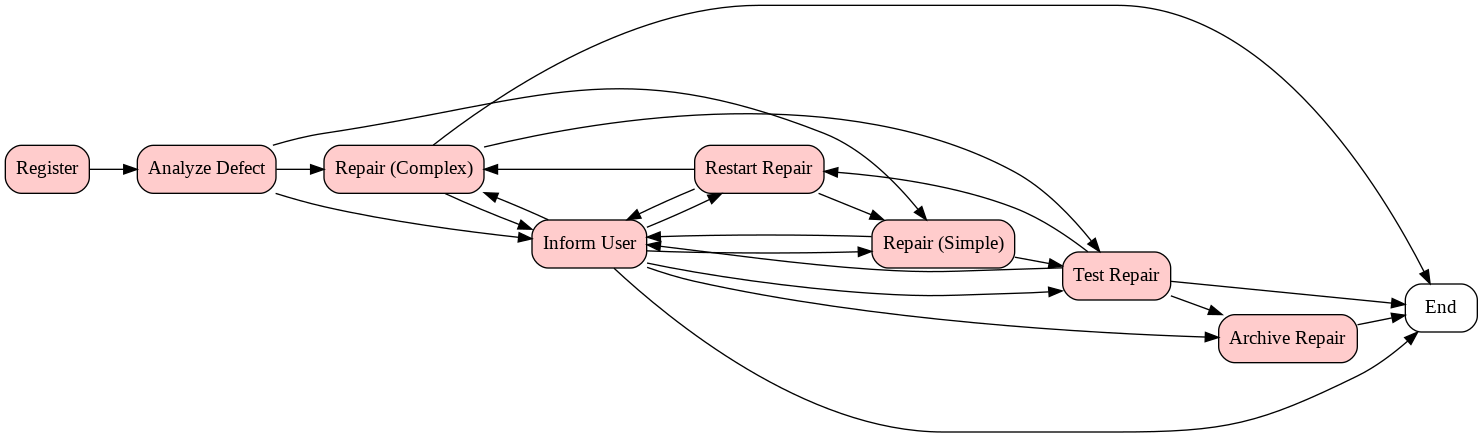

In [188]:
G = pgv.AGraph(strict=False, directed=True)
G.graph_attr['rankdir'] = 'LR'
G.node_attr['shape'] = 'Mrecord'
for event, succesors in w_net.items():
  G.add_node(event, style="rounded,filled", fillcolor="#ffcccc")
  G.add_edges_from([(event, sc) for sc in succesors])
G.draw('simple_heuristic_net.png', prog='dot')
display(Image('simple_heuristic_net.png'))

## Udoskonalanie modelu procesu 

Aby lepiej zobrazować proces warto dodać odpowiednie kolory dla zadań \\
i zróżnicować grubości przepływów, w zależności od tego, \\
jak często w logu występowało odpowiednio dane zdarzenie albo przepływ. 

W tym celu potrzebujemy określić minimalne i maksymalne wartości:

In [189]:
trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
trace_min = trace_counts[0]
trace_max = trace_counts[-1]
color_min = ev_counter.min()
color_max = ev_counter.max()

Teraz możemy do naszego modelu dodać zarówno kolory zadań, jak i grubości linii. \\
Ponadto dodamy do naszego modelu zdarzenie początkowe i zmienimy sposób wyświetlania \\
zarówno zdarzenia początkowego, jak i końcowego.

In [190]:
# G = pgv.AGraph(strict= False, directed=True)
# G.graph_attr['rankdir'] = 'LR'
# G.node_attr['shape'] = 'Mrecord'

# G.add_node("start", shape="circle", label="")
# for ev_start in ev_start_set:
#   G.add_edge("start", ev_start)

# for event, succesors in w_net.items():
#   value = ev_counter[event]
#   color = int(float(color_min-value)/float(color_min-color_max)*100.00)
#   my_color = "#ff9933"+str(hex(color))[2:]
#   G.add_node(event, style="rounded,filled", fillcolor=my_color)
#   for succesor, cnt in succesors.items():
#     G.add_edge(event, succesor, penwidth=4*cnt/(trace_max-trace_min)+0.1, label=cnt)

# G.add_node("end", shape="circle", label="", penwidth='3')
# for ev_end in ev_end_set:
#   G.add_edge(ev_end, "end")

# G.draw('simple_heuristic_net_with_events.png', prog='dot')
# display(Image('simple_heuristic_net_with_events.png'))

KeyError: ignored

## Ćwiczenia rozszerzające model

1. Zmodyfikuj etykiety zadań w modelu, tak by dla każdego zadania oprócz nazwy wyświetlana była także liczba wystąpień odpowiadającego mu zdarzenia w logu. 
Dodaj opcję filtrowania (po zdarzeniach lub przepływach) w zależności od określonych progów, aby pokazać lub ukryć zadania lub przepływy zgodnie z wybranym progiem. Zaprezentuj modele dla wybranych progów np. 420 dla przepływów, 700 dla zdarzeń (osobno i razem). 

2. Dodaj możliwość ustawiania progów przez użytkownika (poprzez podanie liczby lub użycie suwaka z `ipywidgets`) i wyświetlania przefiltrowanego modelu. Przetestuj jego działanie na różnych progach, aby określić, czy model wygląda prawidłowo, w szczególności, czy jakieś zdania nie zostają odczepione od modelu lub nie są prawidłowo połączone z modelem, np. jeśli wcześniej zadanie występowało pomiędzy innymi zadaniami nie należy filtrować wszystkich przepływów, nawet jeśli są poniżej progu.

3. Zmodyfikuj progowanie, tak aby w takim wypadku zachować najlepszy przepływ, aby zadanie było połączone z pozostałymi co najmniej jednym wchodzącym i co najmniej jednym wychodzącym przepływem. Zaprezentuj modele po prostej filtracji i porównaj je z modelami po poprawionej filtracji.

4. Dodaj perspektywę wydajności, tzn. oblicz średni czas trwania i pokoloruj zadania zgodnie z czasem ich trwania, a przepływy odpowiedniej grubości.

5. Na podstawie obserwacji otrzymanego modelu, jakie wnioski można wyciągnąć z odkrytego procesu naprawy telefonów? Pomyśl o kilku wnioskach wynikających z obserwacji modelu i dotyczących odkrytego procesu, najlepiej takich, które nie są oczywiste, czy ogólne (dotyczące dowolnych modeli procesów).  

6. (*nadobowiązkowe*) Istnieją biblioteki do animowania grafów np. `GraphvizAnim`. Przy użyciu tego typu biblioteki można pokusić się o wyświetlenie animacji, jak przebiegał proces wg logu (podświetlając odpowiednie elementy). Jak może wyglądać bardzo zaawansowana animacja takiego modelu można zobaczyć w komercyjnym narzędziu [Disco](https://fluxicon.com/disco/).

Zadania mogą być realizowane w parach, natomiast w sprawozdaniu należy podać wtedy imiona i nazwiska osób z pary oraz każda osoba powinna wysłać zadanie/sprawozdanie przez system MS Teams osobno. 

W sprawozdaniu należy umieścić odpowiednie krótkie opisy z realizacji poszczególnych punktów, zrzuty ekranu oraz kod źródłowy (istotne fragmenty kodu ze zmianami). 

Sprawozdanie z wykonanych ćwiczeń należy przesłać przez platformę MS Teams do 24.03.2022 w postaci:
  - pdf z raportem o wykonaniu ćwiczeń,
  - ipynb z wykonanymi ćwiczeniami (pdf oraz ipynb).


## Dodatkowe informacje

Podobne modele, do tych odkrywanych w czasie laboratorium, można odkryć i eksplorować przy użyciu np. komercyjnego oprogramowania [Disco](https://fluxicon.com/disco/). Z kolei dużo więcej algorytmów i modeli jest zaimplementowanych w oprogramowaniu open-source [ProM](http://www.promtools.org/), jednakże jego obsługa jest dość skomplikowana.

Dziękuję za udział w zajęciach! \\
Krzysztof Kluza \\
kluza@agh.edu.pl
